# New Lyric Creator and Song Lyric Prediction

### Importing all the necessary libraries
1. Tokenize: to tokenize the words/lyrics of the songs
2. Pad_sequences: to ensure that all the inputs are of the same length 
3. String: to clean the text(punctuations, extra whitespaces etc.)

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

### Getting the dataset
The dataset was imported from Kaggle.
One can download the dataset using the below mentioned link:

https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8

In [0]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-06-11 12:50:35--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.138, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ksopnst2irna4qb351ucqdr6udjmclt/1591879800000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-06-11 12:50:38--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ksopnst2irna4qb351ucqdr6udjmclt/1591879800000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.28.132, 2607:f8b0:400e:c04::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|74.125.

#### Text Preprocessing:
Converting the lyrics to tokens and refining our corpus(i.e. lyrics) by removing punctuations, converting all string to lower and getting rid of extra whitespaces which might reduce the models efficiency.

In [0]:
def tokenize_corpus(corpus, num_words=-1):
  if num_words > -1:
    tokenizer=Tokenizer(num_words=num_words, oov_token='<OOV>')
  else:
    tokenizer=Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  #Removing all punctuations
  dataset[field]=dataset[field].str.replace('[{}]'.format(string.punctuation), '')

  #Make everything lower case
  dataset[field]=dataset[field].str.lower()

  #Make it one long string to split by line
  lyrics=dataset[field].str.cat()
  corpus=lyrics.split('\n')

  #Removing any trailing whitespace
  for l in range(len(corpus)):
    corpus[l]=corpus[l].rstrip()

  #Remove any empty lines
  corpus=[l for l in corpus if l != ' ']

  return corpus

### Importing the dataset

#### Songs by Eminem, Coldplay and Sia due to performance restrictions
We will be training our network to the songs of these selected artists due to system performance issues. If that weren't the case, we could have opted to train our network on all the artists present in the dataset.


In [0]:
data = pd.read_csv('/tmp/songdata.csv', dtype=str)
df = data.loc[data['artist'].isin(['Coldplay','Sia','Eminem'])]
df

,artist,song,link,text
3253,Coldplay,Another's Arms,/c/coldplay/anothers+arms_21079526.html,Late night watching tv \nUsed to be you here ...
3254,Coldplay,Bigger Stronger,/c/coldplay/bigger+stronger_20032648.html,I want to be bigger stronger drive a faster ca...
3255,Coldplay,Daylight,/c/coldplay/daylight_20032625.html,"To my surprise, and my delight \nI saw sunris..."
3256,Coldplay,Everglow,/c/coldplay/everglow_21104546.html,"Oh, they say people come \nThey say people go..."
3257,Coldplay,Every Teardrop Is A Waterfall,/c/coldplay/every+teardrop+is+a+waterfall_2091...,"I turn the music up, I got my records on \nI ..."
...,...,...,...,...
51636,Sia,The Church Of What's Happening Now,/s/sia/the+church+of+whats+happening+now_20472...,"I want to change, to rearrange \nWhat is goin..."
51637,Sia,The Fight,/s/sia/the+fight_20551724.html,We are born \nWithout a care \nAs we grow ol...
51638,Sia,Where I Belong,/s/sia/where+i+belong_20472785.html,Without truth \nWe lose \nYet we want to spa...
51639,Sia,You Have Been Loved,/s/sia/you+have+been+loved_20662898.html,"You shot me up, yeah \nYou filled my cup, oh ..."


The dataset consists of 4 columns, namely artist, song, link(of the song), lyric.

This dataset consists of 267 songs in total. 


In [0]:
#Coldplay alone makes up for 120 songs
data = pd.read_csv('/tmp/songdata.csv', dtype=str)
df1 = data.loc[data['artist'].isin(['Coldplay'])]
df1

,artist,song,link,text
3253,Coldplay,Another's Arms,/c/coldplay/anothers+arms_21079526.html,Late night watching tv \nUsed to be you here ...
3254,Coldplay,Bigger Stronger,/c/coldplay/bigger+stronger_20032648.html,I want to be bigger stronger drive a faster ca...
3255,Coldplay,Daylight,/c/coldplay/daylight_20032625.html,"To my surprise, and my delight \nI saw sunris..."
3256,Coldplay,Everglow,/c/coldplay/everglow_21104546.html,"Oh, they say people come \nThey say people go..."
3257,Coldplay,Every Teardrop Is A Waterfall,/c/coldplay/every+teardrop+is+a+waterfall_2091...,"I turn the music up, I got my records on \nI ..."
...,...,...,...,...
28183,Coldplay,Hymn For The Weekend,/c/coldplay/hymn+for+the+weekend_21104544.html,"Oh, angel sent from up above \nYou know you m..."
28184,Coldplay,In My Place,/c/coldplay/in+my+place_20032629.html,"In my place, in my place \nWere lines that I ..."
28185,Coldplay,Ink,/c/coldplay/ink_21082518.html,"Got a tattoo that says ""2gether thru life"" \n..."
28186,Coldplay,Ladder To The Sun,/c/coldplay/ladder+to+the+sun_20232934.html,From the very start \nIt came apart \nIt bro...


##### Now, lets have a look at how the data after preprocessing looks.

In [0]:
# Read the dataset from csv - just first 10 songs for now
#dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(df, 'text')

# Tokenize the corpus
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)
print(corpus)

{'i': 1, 'you': 2, 'the': 3, 'and': 4, 'a': 5, 'to': 6, 'in': 7, 'it': 8, 'me': 9, 'oh': 10, 'my': 11, 'on': 12, 'of': 13, 'all': 14, 'your': 15, 'dont': 16, 'im': 17, 'so': 18, 'that': 19, 'is': 20, 'for': 21, 'its': 22, 'be': 23, 'when': 24, 'know': 25, 'just': 26, 'go': 27, 'come': 28, 'we': 29, 'up': 30, 'see': 31, 'but': 32, 'yeah': 33, 'what': 34, 'are': 35, 'youre': 36, 'if': 37, 'down': 38, 'love': 39, 'this': 40, 'no': 41, 'do': 42, 'want': 43, 'never': 44, 'have': 45, 'gonna': 46, 'like': 47, 'was': 48, 'now': 49, 'let': 50, 'they': 51, 'got': 52, 'how': 53, 'world': 54, 'where': 55, 'say': 56, 'time': 57, 'get': 58, 'not': 59, 'one': 60, 'can': 61, 'cant': 62, 'feel': 63, 'cause': 64, 'with': 65, 'as': 66, 'could': 67, 'way': 68, 'ill': 69, 'lost': 70, 'life': 71, 'out': 72, 'from': 73, 'ooh': 74, 'head': 75, 'at': 76, 'heart': 77, 'always': 78, 'will': 79, 'sun': 80, 'ever': 81, 'youll': 82, 'then': 83, 'light': 84, 'every': 85, 'sky': 86, 'here': 87, 'there': 88, 'us': 89,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Creating Sequences and Labels

We will be using the concepts of n_gram_sequence and one hot encoding to come up with the lyrics for a particular song.

1. N_gram_sequence: It is the simplest model that assigns probabilities to sentences and sequences of words. You can think of an N-gram as the sequence of N words, by that notion, a 2-gram (or bigram) is a two-word sequence of words like “please turn”, “turn your”, or ”your homework”

2. One Hot Encoding: One hot encoding is a process by which categorical variables are converted into a form that could be provided to algorithms to do a better job in prediction.


In [0]:
sequences=[]

for line in corpus:
  token_list=tokenizer.texts_to_sequences([line])[0]
  #print(token_list)
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i+1]
    #print(n_gram_sequence)
    sequences.append(n_gram_sequence)

#Padding for equal length 
max_sequence_length=max([len(seq) for seq in sequences])
sequences=np.array(pad_sequences(sequences=sequences, maxlen=max_sequence_length, padding='pre'))
print(sequences)
# Split sequences between the "input" sequence and "output" predicted word
input_sequences = sequences[:,:-1]
labels =  sequences[:,-1]
print(input_sequences)
print(labels)
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

[[  0   0   0 ...   0 528 128]
 [  0   0   0 ... 528 128 418]
 [  0   0   0 ... 128 418 589]
 ...
 [  0   0   0 ... 329   3 212]
 [  0   0   0 ...   3 212 588]
 [  0   0   0 ... 212 588 175]]
[[  0   0   0 ...   0   0 528]
 [  0   0   0 ...   0 528 128]
 [  0   0   0 ... 528 128 418]
 ...
 [  0   0   0 ... 144 329   3]
 [  0   0   0 ... 329   3 212]
 [  0   0   0 ...   3 212 588]]
[128 418 589 ... 212 588 175]


After looking at the above output it is more understandable that how n-gram and sequences work for our use case

In [0]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['hymn'])
print(tokenizer.word_index['weekend'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

86
362
[  0   0   0   0   0   0   0   0   0   0   0 379   6  23]
[  0   0   0   0   0   0   0   0   0   0 379   6  23   2]
[0. 0. 1. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Train a Text Generation Model
Building an RNN to train our text generation model using categorical_crossentorpy as our loss and accuracy as our metric.

We will be using an Embedding Layer to create n- embedding dimensions to enhance our performance. We will the ouput of the embedding layer to the bi-directional Long Short Term Memory (LSTM) layer. It's remember gate and forget gate will play a big part in predicting the lyric. We will add or remove these depending on the system performace. Finally, we have a Dense layer as our ouptut layer with the activation function 'softmax'.

From there, we should also consider using more epochs than before, as text generation can take a little longer to converge than sentiment analysis, and we aren't working with all that much data yet. I'll start with at 20 epochs here to get a rough estimate of how long does it take, plus we'll only use part of the dataset, and training will tail off quite a bit over that many epochs.

#### Model 1:

2 LSTM Layers with 64 filters and 64 embedded dimensions and 20 epochs

Accuracy achieved: 47%

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=20, verbose=1)

Epoch 1/20
4/4 [==============================] - 0s 7ms/step - loss: 3.8676 - accuracy: 0.0469
Epoch 2/20
4/4 [==============================] - 0s 6ms/step - loss: 3.8457 - accuracy: 0.1094
Epoch 3/20
4/4 [==============================] - 0s 8ms/step - loss: 3.8154 - accuracy: 0.1094
Epoch 4/20
4/4 [==============================] - 0s 6ms/step - loss: 3.7575 - accuracy: 0.1094
Epoch 5/20
4/4 [==============================] - 0s 6ms/step - loss: 3.6534 - accuracy: 0.1094
Epoch 6/20
4/4 [==============================] - 0s 7ms/step - loss: 3.4889 - accuracy: 0.1094
Epoch 7/20
4/4 [==============================] - 0s 7ms/step - loss: 3.4171 - accuracy: 0.1094
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 3.3458 - accuracy: 0.1094
Epoch 9/20
4/4 [==============================] - 0s 6ms/step - loss: 3.2648 - accuracy: 0.1406
Epoch 10/20
4/4 [==============================] - 0s 6ms/step - loss: 3.1785 - accuracy: 0.1016
Epoch 11/20
4/4 [======================

##### Not bad, it took a couple minutes but executed faster than I expected. Now that we have a rough idea of how long it takes for 20 epochs, we can manipulate that value and also try adding a few extra layers and embedding dimensions to increase the accuracy.

#### Model 2

2 LSTM layers one with 32 filter and the other one with 16, with 32 embedded dimensions and 100 epochs

Accuracy achieved: 46

In [0]:
model1 = Sequential()
model1.add(Embedding(total_words, 32, input_length=max_sequence_length-1))
model1.add(Bidirectional(LSTM(32, return_sequences=True)))
model1.add(Bidirectional(LSTM(16)))
model1.add(Dense(total_words, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history1 = model1.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1557/1557 [==============================] - 19s 12ms/step - loss: 6.3272 - accuracy: 0.0440
Epoch 2/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.9296 - accuracy: 0.0516
Epoch 3/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.7702 - accuracy: 0.0562
Epoch 4/100
1557/1557 [==============================] - 20s 13ms/step - loss: 5.6268 - accuracy: 0.0664
Epoch 5/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.5002 - accuracy: 0.0803
Epoch 6/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.3969 - accuracy: 0.0928
Epoch 7/100
1557/1557 [==============================] - 18s 12ms/step - loss: 5.3084 - accuracy: 0.0992
Epoch 8/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.2128 - accuracy: 0.1071
Epoch 9/100
1557/1557 [==============================] - 19s 12ms/step - loss: 5.1227 - accuracy: 0.1132
Epoch 10/100
1557/1557 [==============================]

#### Model 3:

It is evident from Model 2 that decreasing the filters in LSTM layers is doing no good to our model, hence let's increase it to 64 and try with 150 epochs.

Accuracy achieved: 75%

Phew; that was never ending!

In [0]:
model2 = Sequential()
model2.add(Embedding(total_words, 32, input_length=max_sequence_length-1))
model2.add(Bidirectional(LSTM(64, return_sequences=True)))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy'
    , optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(input_sequences, one_hot_labels, epochs=150, verbose=1)

Epoch 1/150
1557/1557 [==============================] - 18s 12ms/step - loss: 6.2288 - accuracy: 0.0472
Epoch 2/150
1557/1557 [==============================] - 18s 11ms/step - loss: 5.7327 - accuracy: 0.0622
Epoch 3/150
1557/1557 [==============================] - 18s 12ms/step - loss: 5.4810 - accuracy: 0.0836
Epoch 4/150
1557/1557 [==============================] - 18s 12ms/step - loss: 5.2649 - accuracy: 0.1056
Epoch 5/150
1557/1557 [==============================] - 18s 11ms/step - loss: 5.0904 - accuracy: 0.1221
Epoch 6/150
1557/1557 [==============================] - 18s 12ms/step - loss: 4.9415 - accuracy: 0.1344
Epoch 7/150
1557/1557 [==============================] - 18s 12ms/step - loss: 4.8101 - accuracy: 0.1449
Epoch 8/150
1557/1557 [==============================] - 18s 12ms/step - loss: 4.6890 - accuracy: 0.1552
Epoch 9/150
1557/1557 [==============================] - 18s 12ms/step - loss: 4.5784 - accuracy: 0.1631
Epoch 10/150
1557/1557 [==============================]

#### Model 4:
Let's give it a final try with 96 embedded dimensions and 96 filters in both the LSTM layers with 150 epochs

BAM!!

Accuracy achieved is 83%, highest till now. But this network is very exhausting to the system. We can achieve an accuracy of more by changing the hyperparameters of the layers, you get my point.

In [0]:
model3 = Sequential()
model3.add(Embedding(total_words, 96, input_length=max_sequence_length-1))
model3.add(Bidirectional(LSTM(96, return_sequences=True)))
model3.add(Bidirectional(LSTM(96)))
model3.add(Dense(total_words, activation='softmax'))
model3.compile(loss='categorical_crossentropy'
    , optimizer='adam', metrics=['accuracy'])
history3 = model3.fit(input_sequences, one_hot_labels, epochs=150, verbose=1)

Epoch 1/150
1992/1992 [==============================] - 35s 17ms/step - loss: 6.4510 - accuracy: 0.0449
Epoch 2/150
1992/1992 [==============================] - 36s 18ms/step - loss: 5.8379 - accuracy: 0.0766
Epoch 3/150
1992/1992 [==============================] - 37s 19ms/step - loss: 5.5407 - accuracy: 0.0944
Epoch 4/150
1992/1992 [==============================] - 37s 19ms/step - loss: 5.3104 - accuracy: 0.1083
Epoch 5/150
1992/1992 [==============================] - 37s 18ms/step - loss: 5.0946 - accuracy: 0.1274
Epoch 6/150
1992/1992 [==============================] - 37s 19ms/step - loss: 4.8772 - accuracy: 0.1430
Epoch 7/150
1992/1992 [==============================] - 37s 19ms/step - loss: 4.6824 - accuracy: 0.1589
Epoch 8/150
1992/1992 [==============================] - 37s 18ms/step - loss: 4.5073 - accuracy: 0.1744
Epoch 9/150
1992/1992 [==============================] - 37s 19ms/step - loss: 4.3442 - accuracy: 0.1897
Epoch 10/150
1992/1992 [==============================]

#### We can get an estimate of what a good number could be for epochs; we can get this by plotting the epoch graph against accuracy of the model. In the graph there will be a point where the graph tends to plateau. The epoch where the graph begins to plateau is generally a good estimate of the number of epochs needed to reach the maximum achievable accuracy for a particular network.

In the figure below, you can se that the graph tends to plateau araound 95 epochs.

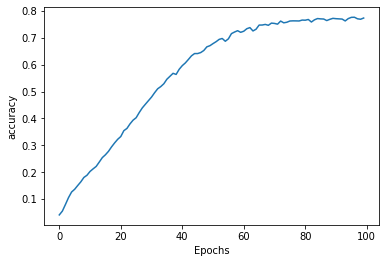

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history4, 'accuracy')

In [0]:
model4 = Sequential()
model4.add(Embedding(total_words, 96, input_length=max_sequence_length-1))
model4.add(Bidirectional(LSTM(96, return_sequences=True)))
model4.add(Bidirectional(LSTM(96, return_sequences=True)))
model4.add(Bidirectional(LSTM(96)))
model4.add(Dense(total_words, activation='softmax'))
model4.compile(loss='categorical_crossentropy'
    , optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
562/562 [==============================] - 8s 14ms/step - loss: 6.0421 - accuracy: 0.0411
Epoch 2/100
562/562 [==============================] - 8s 14ms/step - loss: 5.5395 - accuracy: 0.0553
Epoch 3/100
562/562 [==============================] - 8s 14ms/step - loss: 5.2514 - accuracy: 0.0800
Epoch 4/100
562/562 [==============================] - 8s 14ms/step - loss: 5.0345 - accuracy: 0.1055
Epoch 5/100
562/562 [==============================] - 8s 14ms/step - loss: 4.8383 - accuracy: 0.1263
Epoch 6/100
562/562 [==============================] - 8s 14ms/step - loss: 4.7041 - accuracy: 0.1365
Epoch 7/100
562/562 [==============================] - 8s 14ms/step - loss: 4.5463 - accuracy: 0.1506
Epoch 8/100
562/562 [==============================] - 8s 14ms/step - loss: 4.4141 - accuracy: 0.1642
Epoch 9/100
562/562 [==============================] - 8s 14ms/step - loss: 4.2822 - accuracy: 0.1805
Epoch 10/100
562/562 [==============================] - 8s 14ms/step - loss: 4.158

#### Now, let's test our  best model i.e. Model 4 for random set of words!

We have to tokenize these words and pad the as well before feeding them to our model. We are using np.argmax to decide the predicted word as we have used on-hot encoding and the word with ost probably have an argument of 1 in an np.array() as compared to others which will have 0.

### Generate new Lyrics

In [0]:
seed_text = 'I wanna'
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
	predicted = np.argmax(model4.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

I wanna die in your arms and your legs are shattered could be my golden honest


Here's our model's prediction to the input "I wanna" restraining it to next 10 words only; to be frank, I like it and probably is better than what I personally could have done :P.

Jokes aside, with 83% accuracy we can achieve this. Just imagine what could be acheived when 98+% accuracy is achieved. 

Of course that is no piece of cake and will need high performance systems, but it is acheivable!

### Saving the model as SavedModel in TF
 We do this so that we can re-use the models on other platforms without having to rerun it entirely saving alot of time.

 Saving the model saves the biases and weights attached to the hidden layers. This means that the model won't be compromised when working in a different environment.

In [0]:
import tensorflow_hub as hub
import time

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model4, export_path_sm)

./1591851237
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./1591851237/assets


In [0]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 19, 32)            132736    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 19, 128)           49664     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 4148)              535092    
Total params: 816,308
Trainable params: 816,308
Non-trainable params: 0
_________________________________________________________________


In [0]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

### Downloading Model

In [0]:
!zip -r model.zip {export_path_sm}

  adding: 1591851237/ (stored 0%)
  adding: 1591851237/assets/ (stored 0%)
  adding: 1591851237/saved_model.pb (deflated 90%)
  adding: 1591851237/variables/ (stored 0%)
  adding: 1591851237/variables/variables.index (deflated 70%)
  adding: 1591851237/variables/variables.data-00001-of-00002 (deflated 5%)
  adding: 1591851237/variables/variables.data-00000-of-00002 (deflated 21%)


In [0]:
!ls

1591851237  model.zip  sample_data


In [0]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

## Conclusion

Our best acheived an accuracy of 83% when it comes to predicting the next word of the lyrics in a song.

## References:
1. https://towardsdatascience.com/introduction-to-language-models-n-gram-e323081503d9
2. https://www.tensorflow.org/tutorials/keras/save_and_load
3. https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l10c04_nlp_optimizing_the_text_generation_model.ipynb
4. https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### License
Copyright 2020 PRITHVIRAJ PATIL

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.